In [1]:
import numpy as np
from ARMA import ARMA
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC, OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from tqdm import tqdm
import os

In [82]:
case = 'chb01'
sset = 'Train'
fe = 'AR'
modelroot = './models' + '/' + case + '/' + fe


root = './data' + '/' + sset + '/' + case
cclass_a = 'Interictal'
cclass_b = 'Preictal'

interictal_dir = './data' + '/' + sset + '/' + case + '/' + cclass_a
preictal_dir = './data' + '/' + sset + '/' + case + '/' + cclass_b
interictal_files = os.listdir(interictal_dir)[:1]
preictal_files = os.listdir(preictal_dir)[:1]
print(interictal_files)
print(preictal_files)

['chb01_02_interictal.npy']
['chb01_04_preictal.npy']


In [83]:
# load data
interictal_data = []
for i, _ in enumerate(tqdm(interictal_files)):
    # interictal
    filepath = root + '/' + cclass_a + '/' + interictal_files[i]
    data = np.load(filepath)
    interictal_data.append(data)
del data, filepath

preictal_data = []
for i, _ in enumerate(tqdm(preictal_files)):
    # preictal
    filepath = root + '/' + cclass_b + '/' + preictal_files[i]
    data = np.load(filepath)
    preictal_data.append(data)
del data, filepath

interictal_input = np.hstack(interictal_data)
preictal_input = np.hstack(preictal_data)
print('Interictal:', interictal_input.shape, 'Preictal:', preictal_input.shape)
X = np.hstack((interictal_input, preictal_input))
print('All:', X.shape)

100%|██████████| 1/1 [00:00<00:00, 16.66it/s]

Interictal: (23, 230401) Preictal: (23, 230401)
All: (23, 460802)


### Tracking Prediction Signal with Kalman Filter

In [293]:
# online prediction parameters
sig = X                  # Feed input signal
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter
tp = 1/fp                # Prediction interval


rng = np.random.default_rng()
th_n1_n1 = rng.standard_normal((2,1)) # estimate at time n-1 is noise to begin with
P_n1_n1 = 0.001 * np.eye(2) # covariance of estimate at time n-1

# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (of first few samples)
R = 0.02

# Set process noise as covariance of some beta which is the size of variance 0.0001
beta = 0.0009
Q = beta * np.eye(2)
# Q = np.array(
# [[tp**3/3, tp**2/2    ],
#  [tp**2/2,     tp]]
# )*50

modelname = f'{case}_AR_SVM_Linear'
modelpath = modelroot + '/' + modelname + '.joblib'
model = load(modelpath) # load model

print(f'Model: {modelname}')
print(f'Input length: {sig.shape[1]}')
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
print(f'Prediction interval: {tp} s')
print(f'Kalman R:', R)
print(f'Kalman Q:\n', Q)

Model: chb01_AR_SVM_Linear
Input length: 460802
Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz
Prediction interval: 2.0 s
Kalman R: 0.02
Kalman Q:
 [[0.0009 0.    ]
 [0.     0.0009]]


In [294]:
# online prediction
fp = fs/N                                                 # Prediction frequency
t_s = 1/fs                                                # Input signal time period

a_k_list = []                                             # Sequential buffer for  MA samples
a_h_k_list = []                                           # Sequential buffer for AR signal samples
k_list = []                                               # Sequential buffer for time index in prediction point _k
preds = []
kalman_preds = []
y = [1, 1]                                                 # Kalman history (for tracking)

n_c = sig.shape[0]                                         # Number of input channels
n = sig.shape[1]                                           # Total number of input samples
a = 1.8 * np.random.randn(n_c, n_i)                        # Initialise AR coefficients
c = m * np.ones(m)                                         # Initialise MA coefficients
c = c / c.sum()

Ik = N                                                # Window width
for _k in tqdm(range(Ik + n_i, n), desc='Analysing... '): # Sliding window
    if (_k % N == 0):                                 # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik - n_i + 1                   # Starting index of sliding window (end index is maintained by _k)
        a_h = np.zeros((n_c, n_i))                    # AR parameter estimates from samples in window
        for _i in range(n_c):                              # Iterate channels
            x_t = sig[_i, w_start:_k]                      # Multi-channel window over input signal
            N_w = len(x_t)
            ymat = np.zeros((N_w - n_i, n_i))
            yb = np.zeros((N_w - n_i, n_i))
            for _c in range(n_i, 0, -1):              # Past dependency of AR up to model order
                ymat[ : , n_i - _c] = x_t[n_i - _c : -_c]
            yb = x_t[n_i:]
            a_h[_i] = np.linalg.pinv(ymat) @ yb            # Least squares solution to optimal parameters via Moore-Penrose Pseudo Inverse
        a_k = np.zeros((n_c, n_i))
        a_h_k_idx = len(a_h_k_list) - 1                    # Index to most recent block of AR parameters of shape: (n_c, n_i)
        
        
        for _j in range(m):                           # MA smoothing of AR parameters going back m units of time, in timescale k
            if len(a_h_k_list) > m:                   # Only begin smoothing once unit of time elapsed is greater than m
                a_k = c[_j] * a_h_k_list[a_h_k_idx - _j]
        a_k = np.mean(a_k, axis=0)                         # Mean over channels

        # model prediction: classify a_k (feature)
        p = model.predict(a_k.reshape(1, -1))
        preds.append(p)
        
        # track prediction with Kalman filter
        
        # Time series data y
        # set to be the measurements taken from AR process

        y.append(p.item())

        # th_n_n: estimate at time n using all data upto time n
        # th_n_n1: estimate at time n using all data upto time n-1

        # Initialise
        x = np.zeros((2,1))
        
        # Space to store and plot estimated parameters (length)
        th_conv = []

        # First two estimates are initial guesses
        th_conv.append(th_n1_n1[0])

        # Kalman Iteration Loop (univariate observation, start from time step 1)
        for n in range(2, len(y)):
            # Input vector contains past value
            x[0] = y[n-1]
            x[1] = y[n-2]

            # Prediction of state and covariance
            th_n_n1 = th_n1_n1.copy()
            P_n_n1 = P_n1_n1 + Q

            # Innovation: difference between prediction (yh) and error (y_n)
            yh = th_n_n1.T @ x
            en = y[n] - yh # innovation

            # Kalman gain (kn) and innovation variance (den)
            den = x.T @ P_n_n1 @ x + R
            kn = P_n1_n1 @ x / den

            # Posterior update
            th_n_n = th_n_n1 + kn * en
            P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1

            # Save
            th_conv.append(th_n_n)

            # Remember for next step
            th_n1_n1 = th_n_n.copy()
            P_n1_n1 = P_n_n.copy()

        
        # save tracking data
        kalman_preds.append(yh)    
        
        k_list.append(_k)
        a_h_k_list.append(a_h)
        a_k_list.append(a_k)
# k = np.array(k_list)
k = np.hstack(k_list)
a_h_k = np.array(a_h_k_list)
a_k = np.array(a_k_list)
prediction_sig = np.hstack(preds)

Analysing... : 100%|██████████| 460288/460288 [00:19<00:00, 23158.84it/s]


R: 0.02 Q: 0.0009


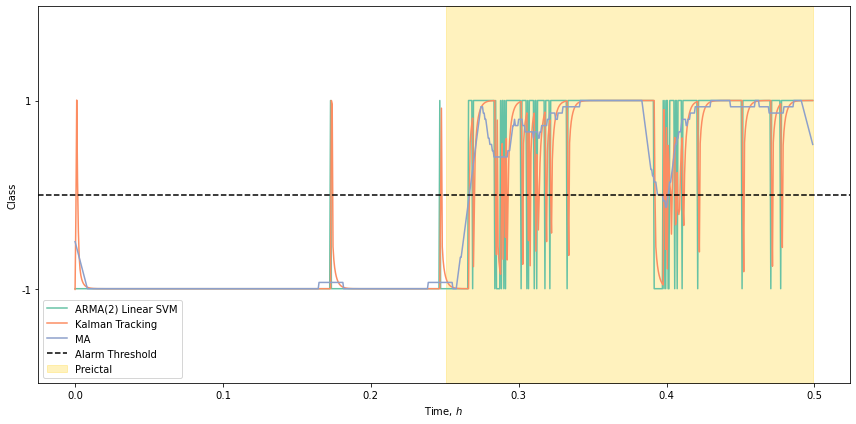

In [304]:
# online predictor response
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600
print('R:', R, 'Q:', beta)
sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
t_preictal = 0.25
m = 30
ma_predict_sig = np.convolve(prediction_sig, np.ones(m)/m, mode='same')
kalman_sig = [k[0] for k in kalman_preds]

ax = sns.lineplot(x=pt, y=prediction_sig, label='ARMA(2) Linear SVM')
sns.lineplot(x=pt, y=np.hstack(kalman_sig), label='Kalman Tracking')
sns.lineplot(x=pt, y=ma_predict_sig, label='MA')
ax.axhline(y=0, ls='--', color='k', label='Alarm Threshold')
# ax.axvline(x=t_preictal, ls='--', color='k', label='Preictal')
# ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.6, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

# plt.xticks(np.arange(0,3.76,0.25))
tickpos = [-1,1] # show only classes: -1 and 1
plt.yticks(tickpos,tickpos)

# plt.xlim([0,3.75])
plt.ylim([-2,2])
plt.xlabel('Time, $h$')
plt.ylabel('Class')
plt.legend(loc=3)
plt.tight_layout()
# plt.savefig('./figures/chb01_AR_SVM_Linear.pdf')
plt.show()

R = 2.000, Q = 0.00090


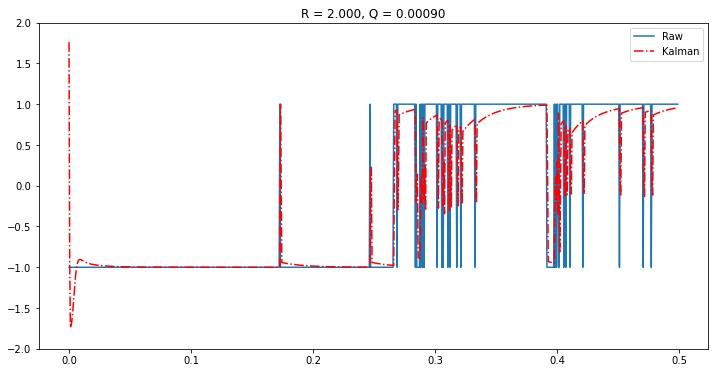

In [178]:
# basic plot
kalman_sig = [k[0] for k in kalman_preds]
# len(kalman_sig)
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pt, prediction_sig, label="Raw")
ax.plot(pt, kalman_sig, ls='-.', c='r', label='Kalman')
# ax.set_xlim(0, 400)
ax.set_ylim(-2, 2)

ax.set_title("Estimation of $a_1, a_2$")


ax.set_title("R = %4.3f, Q = %6.5f"%(R, beta))
print("R = %4.3f, Q = %6.5f"%(R, beta))

plt.legend()
# plt.savefig('../images/ar_params_dyn_estimation.png')
plt.show()

(899, 2)


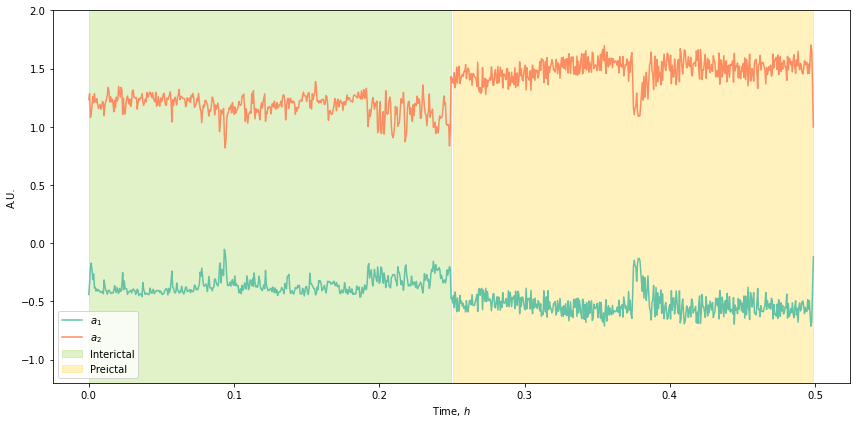

In [199]:
# AR coefficient response
ar_mean = np.mean(a_h_k, axis=1)
print(ar_mean.shape)

sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))
sns.lineplot(x=pt, y=ar_mean[:,0], label='$a_1$')
ax = sns.lineplot(x=pt, y=ar_mean[:,1], label='$a_2$')
ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

# plt.xticks(np.arange(0,3.76,0.25))
# plt.xlim([0,3.75])
plt.ylim([-1.2,2])
plt.xlabel('Time, $h$')
plt.ylabel('A.U.')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/chb01_AR_RT.pdf')
plt.show()

In [236]:
# Experiment: Kalman tracking of AR parameters
# online prediction parameters
sig = X                  # Feed input signal
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = X.shape[0]       # Number of EEG electrodes (channels)
m = 30                   # MA parameter
tp = 1/fp                # Prediction interval


rng = np.random.default_rng()
th_n1_n1 = rng.standard_normal((2,1)) # estimate at time n-1 is noise to begin with
P_n1_n1 = 0.001 * np.eye(2) # covariance of estimate at time n-1

# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (of first few samples)
R = 0.2

# Set process noise as covariance of some beta which is the size of variance 0.0001
beta = 0.0001
Q = beta * np.eye(2)
# Q = np.array(
# [[tp**3/3, tp**2/2    ],
#  [tp**2/2,     tp]]
# )*50

modelname = f'{case}_AR_SVM_Linear'
modelpath = modelroot + '/' + modelname + '.joblib'
model = load(modelpath) # load model

print(f'Model: {modelname}')
print(f'Input length: {sig.shape[1]}')
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
print(f'Prediction interval: {tp} s')
print(f'Kalman R:', R)
print(f'Kalman Q:\n', Q)

Model: chb01_AR_SVM_Linear
Input length: 460802
Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz
Prediction interval: 2.0 s
Kalman R: 0.2
Kalman Q:
 [[0.0001 0.    ]
 [0.     0.0001]]


In [237]:
# Experiment: Kalman tracking of AR parameters

# online prediction
fp = fs/N                                                 # Prediction frequency
t_s = 1/fs                                                # Input signal time period

a_k_list = []                                             # Sequential buffer for  MA samples
a_h_k_list = []                                           # Sequential buffer for AR signal samples
k_list = []                                               # Sequential buffer for time index in prediction point _k
preds = []
kalman_preds_1 = []
kalman_preds_2 = []
y = [1, 1]                                                 # Kalman history (for tracking)

n_c = sig.shape[0]                                         # Number of input channels
n = sig.shape[1]                                           # Total number of input samples
a = 1.8 * np.random.randn(n_c, n_i)                        # Initialise AR coefficients
c = m * np.ones(m)                                         # Initialise MA coefficients
c = c / c.sum()

Ik = N                                                # Window width
for _k in tqdm(range(Ik + n_i, n), desc='Analysing... '): # Sliding window
    if (_k % N == 0):                                 # Decimation policy: _k occurs once every N samples
        w_start = _k - Ik - n_i + 1                   # Starting index of sliding window (end index is maintained by _k)
        a_h = np.zeros((n_c, n_i))                    # AR parameter estimates from samples in window
        for _i in range(n_c):                              # Iterate channels
            x_t = sig[_i, w_start:_k]                      # Multi-channel window over input signal
            N_w = len(x_t)
            ymat = np.zeros((N_w - n_i, n_i))
            yb = np.zeros((N_w - n_i, n_i))
            for _c in range(n_i, 0, -1):              # Past dependency of AR up to model order
                ymat[ : , n_i - _c] = x_t[n_i - _c : -_c]
            yb = x_t[n_i:]
            a_h[_i] = np.linalg.pinv(ymat) @ yb            # Least squares solution to optimal parameters via Moore-Penrose Pseudo Inverse
        a_k = np.zeros((n_c, n_i))
        a_h_k_idx = len(a_h_k_list) - 1                    # Index to most recent block of AR parameters of shape: (n_c, n_i)
        
        
        for _j in range(m):                           # MA smoothing of AR parameters going back m units of time, in timescale k
            if len(a_h_k_list) > m:                   # Only begin smoothing once unit of time elapsed is greater than m
                a_k = c[_j] * a_h_k_list[a_h_k_idx - _j]
        a_k = np.mean(a_k, axis=0)                         # Mean over channels

        # model prediction: classify a_k (feature)
        p = model.predict(a_k.reshape(1, -1))
        preds.append(p)
        
        # track prediction with Kalman filter
        
        # Time series data y
        # set to be the measurements taken from AR process
        a_h_mean = np.mean(a_h, axis=0) 
        y.append(a_h_mean)

        # th_n_n: estimate at time n using all data upto time n
        # th_n_n1: estimate at time n using all data upto time n-1

        # Initialise
        x = np.zeros((2,2))
        
        # Space to store and plot estimated parameters (length)
        th_conv = []
        th_conv_2 = []

        # First two estimates are initial guesses
        th_conv.append(th_n1_n1[0])

        # Kalman Iteration Loop (univariate observation, start from time step 1)
        for n in range(2, len(y)):
            # Input vector contains past value
            x[0] = y[n-1]
            x[1] = y[n-2]

            # Prediction of state and covariance
            th_n_n1 = th_n1_n1.copy()
            P_n_n1 = P_n1_n1 + Q

            # Innovation: difference between prediction (yh) and error (y_n)
            yh = th_n_n1.T @ x
            en = y[n] - yh # innovation

            # Kalman gain (kn) and innovation variance (den)
            den = x.T @ P_n_n1 @ x + R
            kn = P_n1_n1 @ x / den

            # Posterior update
            th_n_n = th_n_n1 + kn * en
            P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1

            # Save
            th_conv.append(th_n_n[0])
            th_conv_2.append(th_n_n[1])
            

            # Remember for next step
            th_n1_n1 = th_n_n.copy()
            P_n1_n1 = P_n_n.copy()

        
        # save tracking data
        kalman_preds_1.append(th_conv)
        kalman_preds_2.append(th_conv_2)
        
        k_list.append(_k)
        a_h_k_list.append(a_h)
        a_k_list.append(a_k)
# k = np.array(k_list)
k = np.hstack(k_list)
a_h_k = np.array(a_h_k_list)
a_k = np.array(a_k_list)
prediction_sig = np.hstack(preds)

Analysing... : 100%|██████████| 460288/460288 [00:24<00:00, 18954.79it/s]


In [283]:
kalman_sig_1 = [k[0][0] for k in kalman_preds_1]
kalman_sig_2 = [k[0][0] for k in kalman_preds_2]

kalman_sig_1 = np.hstack(kalman_sig_1)
kalman_sig_2 = np.hstack(kalman_sig_2)

(899, 2)


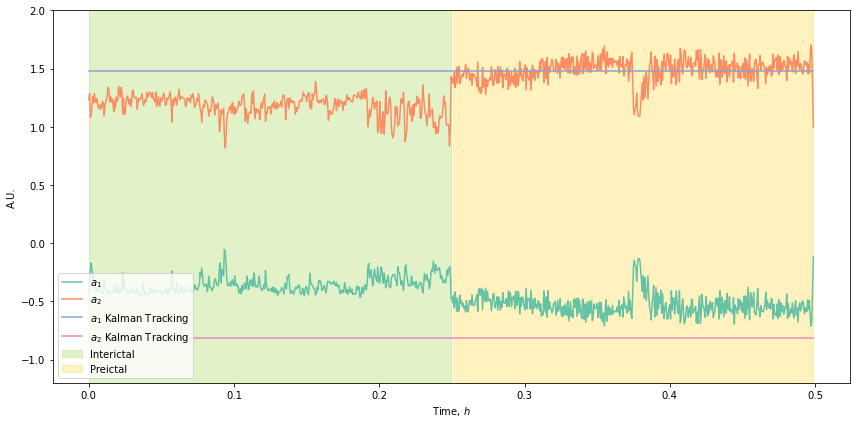

In [288]:
# AR coefficient response
pt = np.arange(0, k.shape[0]) / (fs/N) / 3600
ar_mean = np.mean(a_h_k, axis=1)

sns.set_palette(sns.color_palette('Set2'))
plt.figure(figsize=(12,6))

sns.lineplot(x=pt, y=ar_mean[:,0], label='$a_1$')
ax = sns.lineplot(x=pt, y=ar_mean[:,1], label='$a_2$')

sns.lineplot(x=pt, y=kalman_sig_1[1], label='$a_1$ Kalman Tracking')
sns.lineplot(x=pt, y=kalman_sig_2[1], label='$a_2$ Kalman Tracking')

ax.fill_between(pt, 0, 1, where=pt < t_preictal, color='#9cd34a', alpha=0.3, transform=ax.get_xaxis_transform(), label='Interictal')
ax.fill_between(pt, 0, 1, where=pt > t_preictal, color='#ffd429', alpha=0.3, transform=ax.get_xaxis_transform(), label='Preictal')

plt.ylim([-1.2,2])
plt.xlabel('Time, $h$')
plt.ylabel('A.U.')
plt.legend(loc=3)
plt.tight_layout()
plt.savefig('./figures/kalman_AR_param_tracking.pdf')
plt.show()

---

---